/var/folders/hz/sxjybc2n3672m3dmm7b8ngt80000gp/T/ipykernel_8710/2810937208.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i+1), plt.imshow(images[i], 'gray')


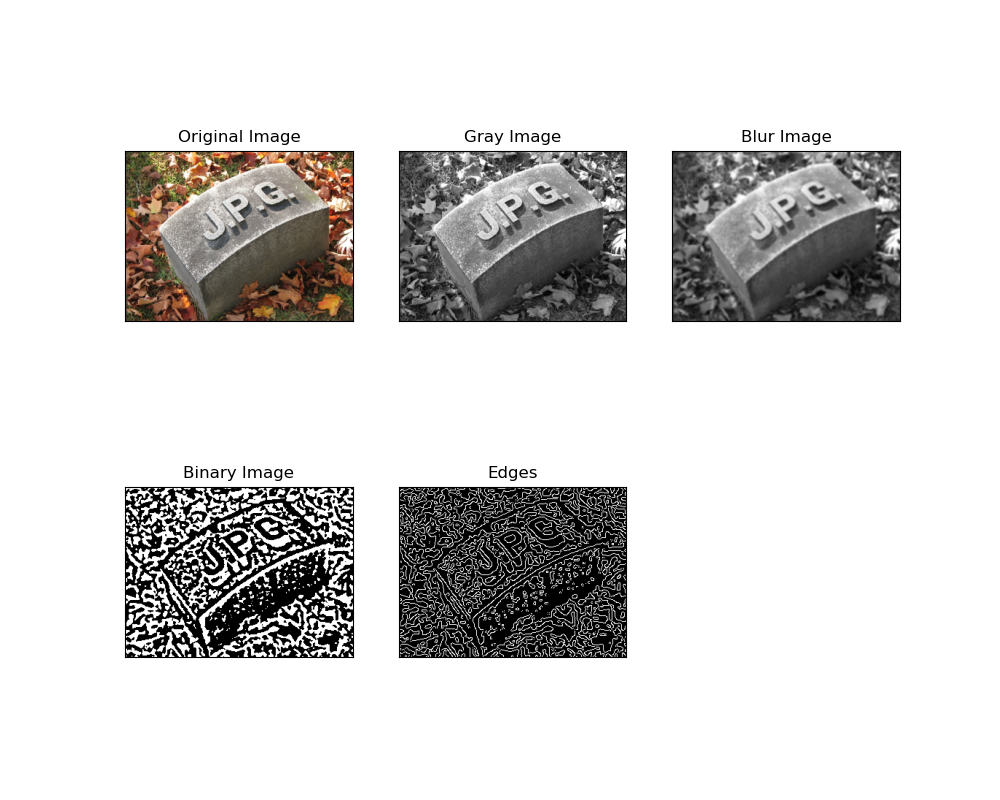

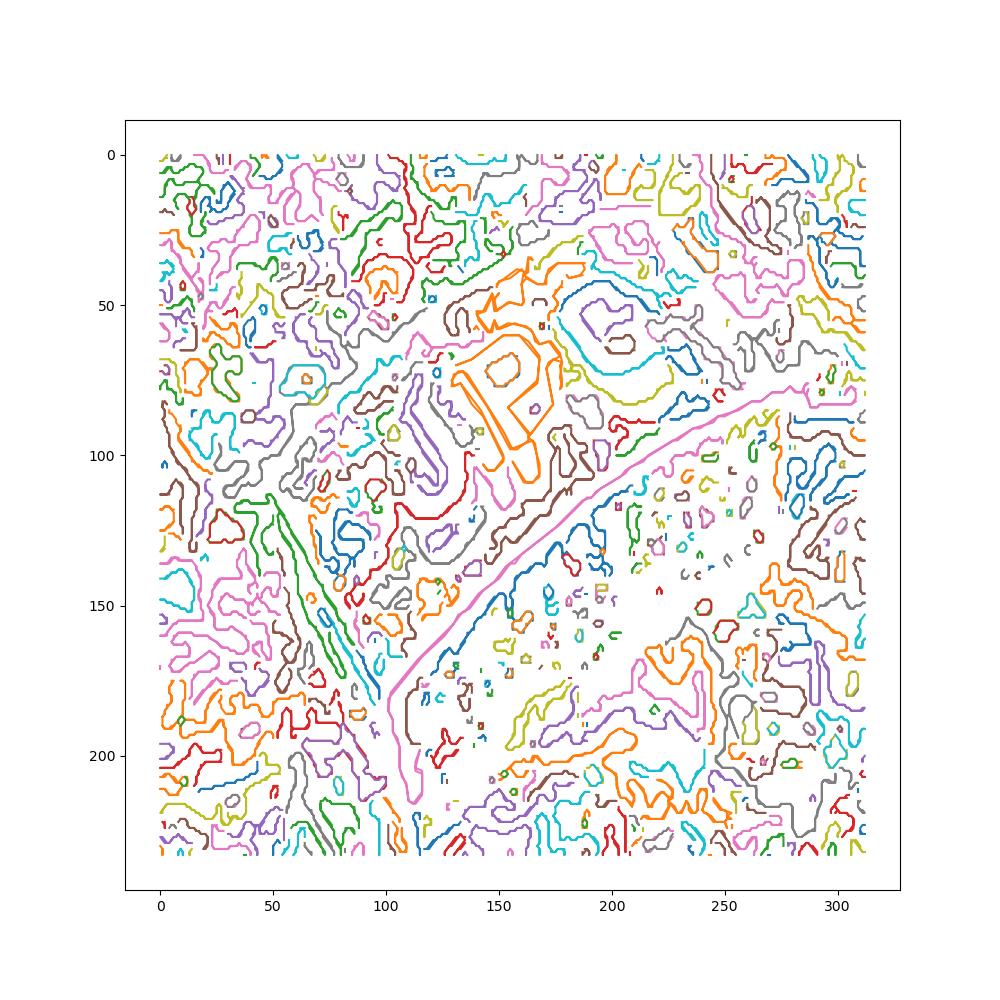

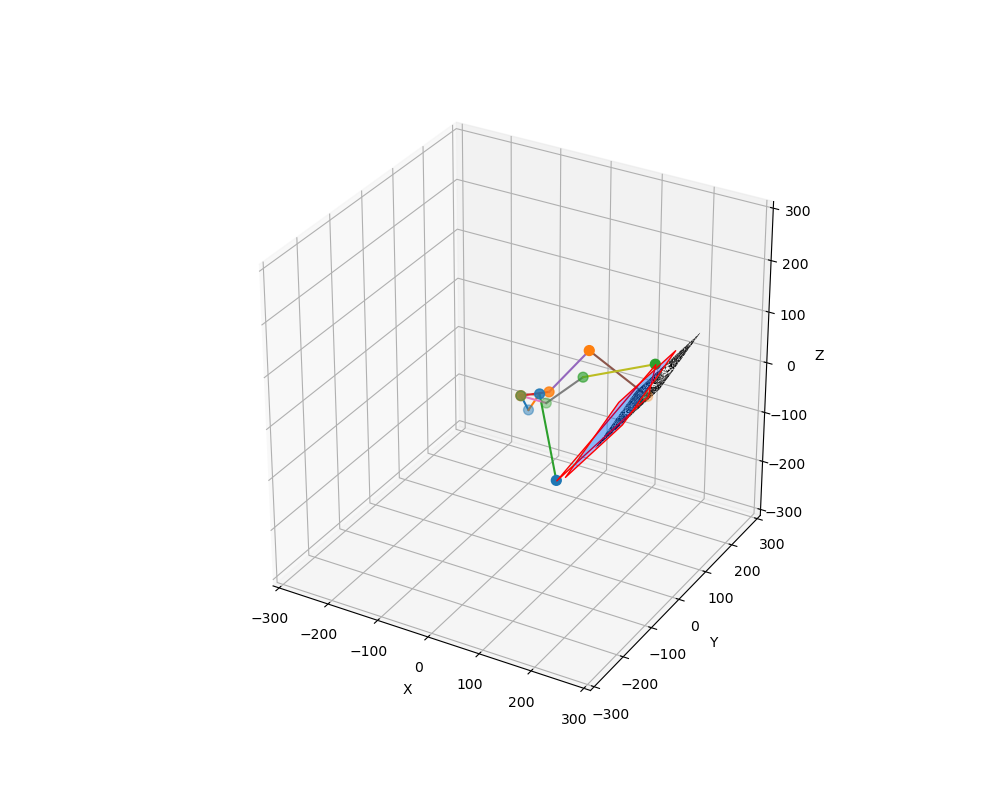

In [4]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from spider_leg import SpiderLeg  # Assuming spider_leg is a module you have access to
import cv2
from math import radians

class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.RGB_img, self.gray, self.blur, self.binary = self.preprocess_image()
        self.edges = self.detect_edges()

    def preprocess_image(self):
        image = cv2.imread(self.image_path)
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        binary = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 3)
        return RGB_img, gray, blur, binary

    def detect_edges(self):
        edges = cv2.Canny(self.binary, 20, 150, apertureSize=3)
        return edges

    def generate_paths(self):
        contours, _ = cv2.findContours(self.edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        paths = []
        for contour in contours:
            epsilon = 0.001 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            path = np.squeeze(approx).tolist()
            if isinstance(path[0], list) or isinstance(path[0], tuple):
                paths.append(path)
        return paths

    def plot_images(self):
        titles = ['Original Image', 'Gray Image', 'Blur Image', 'Binary Image', 'Edges']
        images = [self.RGB_img, self.gray, self.blur, self.binary, self.edges]
        for i in range(5):
            plt.subplot(2, 3, i+1), plt.imshow(images[i], 'gray')
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
        plt.show()

    def plot_paths(self, paths):
        plt.figure(figsize=(10, 10))
        for path in paths:
            if path and isinstance(path, list):
                xs, ys = zip(*path)
                plt.plot(xs, ys)
        plt.gca().invert_yaxis()
        plt.show()

class PlaneProjector:
    @staticmethod
    def plane_normal_from_points(p1, p2, p3):
        v1 = np.array(p2) - np.array(p1)
        v2 = np.array(p3) - np.array(p1)
        normal = np.cross(v1, v2)
        normal = normal / np.linalg.norm(normal)
        return normal

    @staticmethod
    def project_rectangle_on_plane(triangle_points, width, height):
        normal = PlaneProjector.plane_normal_from_points(triangle_points[0], triangle_points[1], triangle_points[2])
        center = np.mean(triangle_points, axis=0)
        if not np.allclose(normal, [1, 0, 0]) and not np.allclose(normal, [0, 1, 0]):
            v1 = np.cross(normal, [1, 0, 0])
        else:
            v1 = np.cross(normal, [0, 0, 1])
        v1 = v1 / np.linalg.norm(v1)
        v2 = np.cross(normal, v1)
        v2 = v2 / np.linalg.norm(v2)
        corners = [center + 0.5 * width * v1 + 0.5 * height * v2,
                   center - 0.5 * width * v1 + 0.5 * height * v2,
                   center - 0.5 * width * v1 - 0.5 * height * v2,
                   center + 0.5 * width * v1 - 0.5 * height * v2]
        return np.array(corners)

    @staticmethod
    def project_path_on_plane(path, plane_normal, plane_point):
        projected_path = []
        for point in path:
            point_on_plane = np.array([point[0], point[1], plane_point[2]])
            vec_to_plane_point = plane_point - point_on_plane
            z_offset = np.dot(vec_to_plane_point, plane_normal
 ) / np.dot(plane_normal, plane_normal)
            intersection_point = point_on_plane + z_offset * plane_normal
            projected_path.append(intersection_point)
        return np.array(projected_path)

    @staticmethod
    def center_paths(paths, rectangle_center):
        all_points = [point for path in paths for point in path]
        min_x = min(all_points, key=lambda x: x[0])[0]
        max_x = max(all_points, key=lambda x: x[0])[0]
        min_y = min(all_points, key=lambda x: x[1])[1]
        max_y = max(all_points, key=lambda x: x[1])[1]
        
        paths_center = [(min_x + max_x) / 2, (min_y + max_y) / 2]
        offset = [rectangle_center[0] - paths_center[0], rectangle_center[1] - paths_center[1]]
        
        centered_paths = [[[point[0] + offset[0], point[1] + offset[1]] for point in path] for path in paths]
        return centered_paths
# Now we can use these classes to perform the operations
# Replace 'rip.jpg' with your actual image path
image_processor = ImageProcessor(image_path='rip.jpg')
image_processor.plot_images()
paths = image_processor.generate_paths()
image_processor.plot_paths(paths)

# Create a spider leg instance for simulation (using example dimensions)
leg = SpiderLeg(name="TestLeg", COXA=50, FEMUR=100, TIBIA=150)

# Configuration of angles for each leg position
angles_config = [
    [radians(-45), radians(45), radians(90)],
    [radians(+45), radians(45), radians(90)],
    [radians(0), radians(45), radians(20)]
]

# Calculate the tip positions and project the rectangle on the plane
tip_positions = [leg.forwardKinematics(angles)[3] for angles in angles_config]
p1, p2, p3 = np.array(tip_positions)
rectangle_center_2d = np.mean(rectangle_corners[:, :2], axis=0)

# Center the paths before projecting them onto the plane
centered_paths = PlaneProjector.center_paths(paths, rectangle_center_2d)
plane_normal = PlaneProjector.plane_normal_from_points(p1, p2, p3)
plane_point = np.mean(rectangle_corners, axis=0)

# Project the centered paths onto the plane
projected_paths = [PlaneProjector.project_path_on_plane(path, plane_normal, plane_point) for path in centered_paths]


class Visualization:
    def __init__(self, leg, angles_config, rectangle_corners, projected_paths):
        self.leg = leg
        self.angles_config = angles_config
        self.rectangle_corners = rectangle_corners
        self.projected_paths = projected_paths

    def plot_leg_positions(self):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Plot each leg position
        for angles in self.angles_config:
            joints = np.array(self.leg.forwardKinematics(angles))
            # Plot joints
            ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], s=50)
            # Connect joints with lines
            for i in range(len(joints) - 1):
                ax.plot([joints[i][0], joints[i + 1][0]], 
                        [joints[i][1], joints[i + 1][1]], 
                        zs=[joints[i][2], joints[i + 1][2]])
        
        # Plot the rectangle and triangle defining the plane
        ax.add_collection3d(Poly3DCollection([list(zip(self.rectangle_corners[:, 0], 
                                                       self.rectangle_corners[:, 1], 
                                                       self.rectangle_corners[:, 2]))], 
                                             facecolors='blue', linewidths=1, edgecolors='r', alpha=.25))
        triangle = np.array([p1, p2, p3])
        ax.add_collection3d(Poly3DCollection([list(zip(triangle[:, 0], 
                                                       triangle[:, 1], 
                                                       triangle[:, 2]))], 
                                             facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))
        
        # Plot the projected paths onto the plane
        for projected_path in self.projected_paths:
            ax.plot(projected_path[:, 0], projected_path[:, 1], projected_path[:, 2], 'k-', linewidth=0.1)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        limits = [-300, 300]
        ax.set_xlim(limits)
        ax.set_ylim(limits)
        ax.set_zlim(limits)
        ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio
        plt.show()

# Now we create an instance of Visualization and call the plotting method
visualization = Visualization(leg, angles_config, rectangle_corners, projected_paths)
visualization.plot_leg_positions()